# Exploratory data analysis and feature selection: Random Forest

Fabiana Castiblanco

https://github.com/fabi-cast

## Conclusions from modeling task

* By adding the Human Development Index (HDI) to our model, correcting some data about rural population, population and population density, we have a model with R_squared of 0.32 and RMSE 1.1057 (13 people after revert logarithmic transformation). If we consider the capacity of the World Food Program, this RMSE is not too bad considering this is a primer approximation without any hyperparameter tunning.

* If we consider the original dataset, under the same conditions, the R_squared is 0.30 and the RMSE is 1.156 (14 people after revert logarithmic transformation). 


## Questions and comments

1. In which countries have been taking place most cyclones during the last 10 years? Which categories?

According with our data, the top 5 countries with more frequence of cyclones are Philipines, China, Japan, Mexico and Vietnam. By categories, the West Pacific Basin (WP) have more affected people by cyclones category 5 than others. Also, at the Bengal Basin the intensity of the cyclones reported in the data is positively correlated with the number of affected people. However, in the Caribean Sea sub-basin we see an anomaly: according with the data we have more affected people by subtropical events than by cyclones category 5, which is contraintuitive.

2. Is there any correlation between the development of the country and the overall impact of the hazards?

3. How is the dietary composition for the most affected countries?

This would be interesting for our second part of modeling.

4. Cyclone are seasonal events. For a relief plan, we should contextualize the problem at the country level. Consider the country most affected by cyclones over the years. How have been the humanitarian aid from the WFP during these scenarios? What can we say based on data?


## 1. Import libraries


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import math
import requests
import json
import matplotlib
from pandas import ExcelFile
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import geopandas as gp
import reverse_geocoder as rg
import fiona
import ast
import statsmodels.api as sm
import pickle
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
import sklearn
matplotlib.rc('image', cmap='Set3')
from plotly import graph_objects as go
import plotly.express as px
from scicolorscales import *
from plotly.subplots import make_subplots

# 2. Functions to handling data

In [2]:
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

def get_country_list(ds, col):
    
    """
    Returns a list containing the countries or ISO codes in the dataset ds
    """
    return list(ds[col])

#this function converts a row oriented data set in a columns oriented one

def get_data(ds, country, col, col_name):
    
    """
    Creates a dataset for each country containing the features in col_name.
    ds is the original data set, col is the name of the column containing information about
    countries and col_name is the desired feature to get from ds
    """
    ind = get_country_list(ds, col).index(country)
    data = (ds[ds[col] == country].drop(columns = [col])
                                  .T.reset_index()
                                  .rename(columns = {"index": "year", ind: col_name}))
    data["country"] = country
    return data

def get_table(ds, col, col_name):
    
    """
    Creates a dataset column oriented based on row oriented ds
    """
    
    country_list = get_country_list(ds, col)
    datasets = [get_data(ds, country, col, col_name) for country in country_list]
    return pd.concat(datasets).reset_index(drop = True)
    


# 3. Loading data

In [3]:
ds = pd.read_excel("Data_output/final_data.xls").drop(columns = "Unnamed: 0")

In [4]:
ds["COORDS"] = ds.COORDS.apply(lambda x: ast.literal_eval(x))
ds["ISO_TIME"] = ds.ISO_TIME.apply(lambda x: ast.literal_eval(x))

In [5]:
null_cols(ds)

Feature  % Null rows
0   TOTAL_DAMAGE_(000$)    31.914894
1              34KN_POP    23.500967
2           34KN_ASSETS    23.500967
3           96KN_ASSETS    23.500967
4              96KN_POP    23.500967
5           64KN_ASSETS    23.500967
6              64KN_POP    23.500967
7          TOTAL_DEATHS    13.442940
8            pop_max_50     8.607350
9            pop_max_64     8.607350
10           pop_max_34     8.607350
11         STORM_DR_MAX     1.547389
12         STORM_DR_MIN     1.547389
13        STORM_SPD_MAX     1.547389
14        STORM_SPD_MIN     1.547389
15             PRES_MAX     1.547389
16             PRES_MIN     1.547389
17             WIND_MAX     1.547389
18             WIND_MIN     1.547389
19       WIND_CALC_MEAN     0.386847

In [6]:
ds_filter = ds.drop(columns =['34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP','96KN_ASSETS', 'TOTAL_DAMAGE_(000$)'] )

In [7]:
null_cols(ds_filter)

Feature  % Null rows
0     TOTAL_DEATHS    13.442940
1       pop_max_64     8.607350
2       pop_max_50     8.607350
3       pop_max_34     8.607350
4     STORM_DR_MAX     1.547389
5     STORM_DR_MIN     1.547389
6    STORM_SPD_MAX     1.547389
7    STORM_SPD_MIN     1.547389
8         PRES_MAX     1.547389
9         PRES_MIN     1.547389
10        WIND_MAX     1.547389
11        WIND_MIN     1.547389
12  WIND_CALC_MEAN     0.386847

In [8]:
ds_filter.drop(columns = ["DAY_HRS", "NIGHT_HRS", "ISO_TIME"], inplace= True)

# 4. Handling categorical data

## 4.1. Get dummies

Before using dummies encoding we should change the columns ``BASIN`` and ``SUB BASIN`` to be categorical variables.

In [9]:
ds_filter['BASIN'] = ds_filter['BASIN'].astype('category')
ds_filter['SUB BASIN'] = ds_filter['SUB BASIN'].astype('category')
ds_filter['USA_SSHS'] = ds_filter['USA_SSHS'].astype('category')

In [10]:
ds_filter['YEAR'] = ds_filter['YEAR'].astype('category')

In [11]:
# get dummy variables
ds_new = pd.get_dummies(ds_filter, columns=["SUB BASIN", "NATURE"], prefix = ["SUB_BASIN", "NATURE"])# merge with main df bridge_df on key values


In [12]:
ds_new.drop(columns= "BASIN", inplace= True)

## 4.2. Extract median coordinates (lat, lon)

Now we extract the median coordinates of each cyclone path. We consider this geographical feature is very important.

In [13]:
#defining a function to extract the median coordinates

def get_median_coords(list_coords):
    n = len(list_coords)
    index = int(np.median(np.arange(0, n)))
    return list_coords[index]

In [14]:
ds_new["LAT"] = ds_new.COORDS.apply(lambda x: get_median_coords(x)[0])

In [15]:
ds_new["LON"] = ds_new.COORDS.apply(lambda x: get_median_coords(x)[1])

In [16]:
ds_new.drop(columns = "COORDS", inplace= True)

In [17]:
null_cols(ds_new)

Feature  % Null rows
0     TOTAL_DEATHS    13.442940
1       pop_max_64     8.607350
2       pop_max_50     8.607350
3       pop_max_34     8.607350
4     STORM_DR_MAX     1.547389
5     STORM_DR_MIN     1.547389
6    STORM_SPD_MAX     1.547389
7    STORM_SPD_MIN     1.547389
8         PRES_MAX     1.547389
9         PRES_MIN     1.547389
10        WIND_MAX     1.547389
11        WIND_MIN     1.547389
12  WIND_CALC_MEAN     0.386847

## 4.3. Exploring ordinal and categorical data

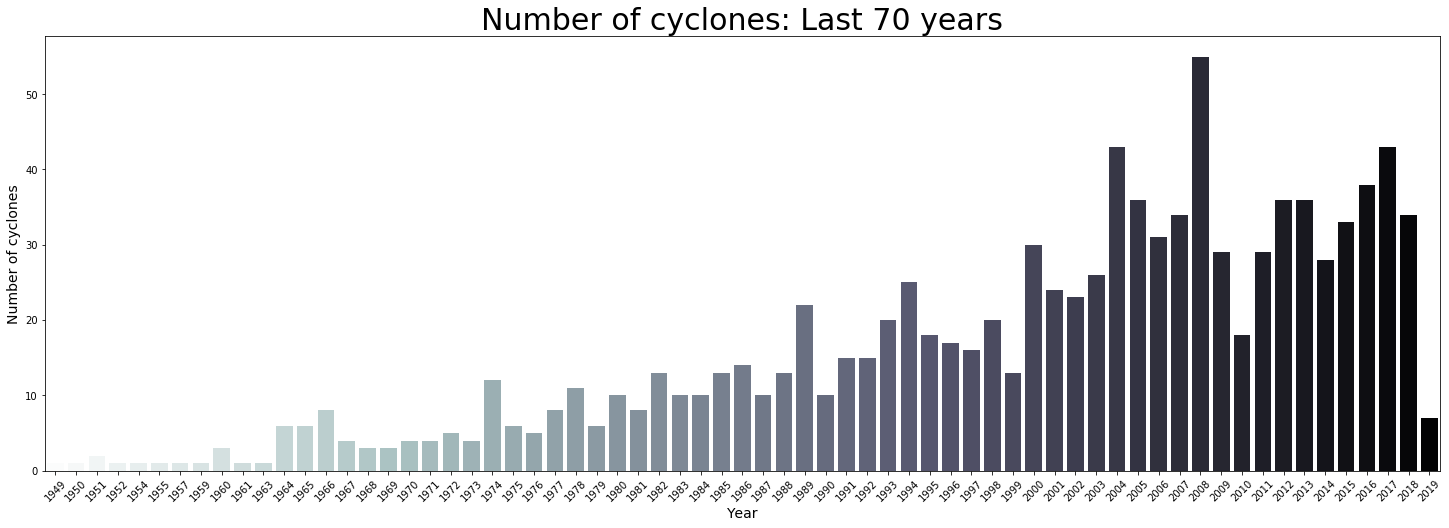

In [18]:
# List of cyclones by occurrence
fig, ax = plt.subplots(figsize=(25,8))
sns.countplot(data = ds_new,
              x= "YEAR",
              palette = "bone_r" ,
              #order= years,
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Number of cyclones: Last 70 years', fontsize = 30)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Year', fontsize=14);


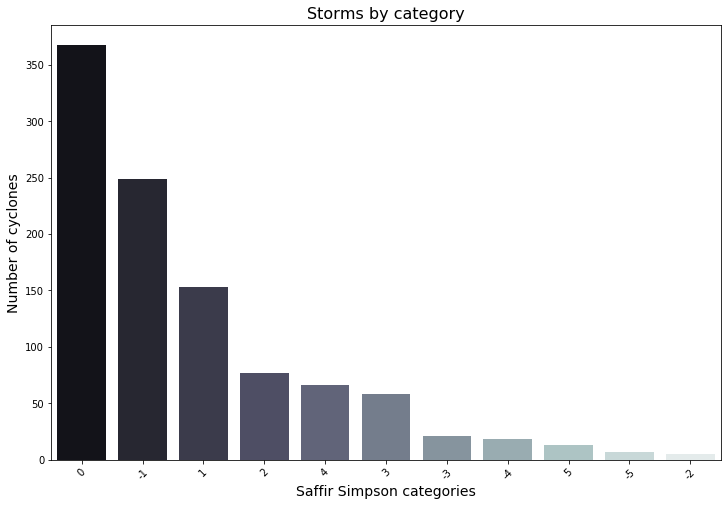

In [19]:
# List of cyclones by occurrence
Saffir_classification= list(ds_new['USA_SSHS'].value_counts().index)
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data = ds_new,
              x= "USA_SSHS",
              order= Saffir_classification,
              palette = "bone",
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Storms by category', fontsize= 16)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Saffir Simpson categories', fontsize=14);


Most of the cyclones in our data set are **Tropical Storms** and **Tropical Depresssions**, which usually don't cause more damage to communities.

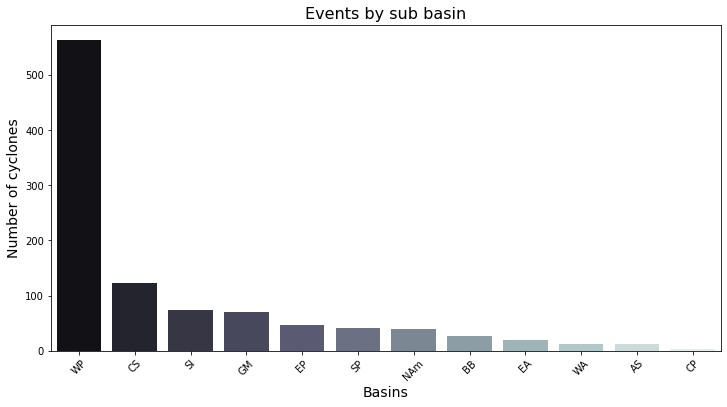

In [20]:
# List of cyclones by occurrence
basins= list(ds_filter['SUB BASIN'].value_counts().index)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(data = ds_filter,
              x= "SUB BASIN",
              palette= "bone",
              order= basins,
              orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('Events by sub basin', fontsize= 16)
ax.set_ylabel('Number of cyclones', fontsize=14);
ax.set_xlabel('Basins', fontsize=14);


By far, most of the storms have occurred in **Western North Pacific** basin.

### Countries with more cyclone frequence

In [21]:
countries_to_plot = ds_filter.groupby("ISO")[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Nº_cyclones"})

In [22]:
fig = px.choropleth(countries_to_plot, locations="ISO",
                    color="Nº_cyclones", 
                    hover_name="ISO", # column to add to hover information
                    color_continuous_scale=oslorev,
                    projection='natural earth')
fig.update_layout(
    title_text = 'Occurrence of cyclones by countries')

fig.show()



Philipines, China, Japan, Mexico, Vietnam, United States and Madagascar are the countries with highest occurrence of cyclones. In GitHub, please see the static image [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/map.png)


For this reason, when studying the relevance of the categorical features as ``BASIN``, ``SUB BASIN`` and ``USA_SSHS`` in the target variable, we can take the aggregated function as the **mean** of the data.

## 4.4. Correlation matrix for categorical features 

We will use contingency tables for analyzing whether there is some correlation between people affected, the sub-basin of the cyclone and the intensity of it according with the Saffir-Simpson-Scale in our data.

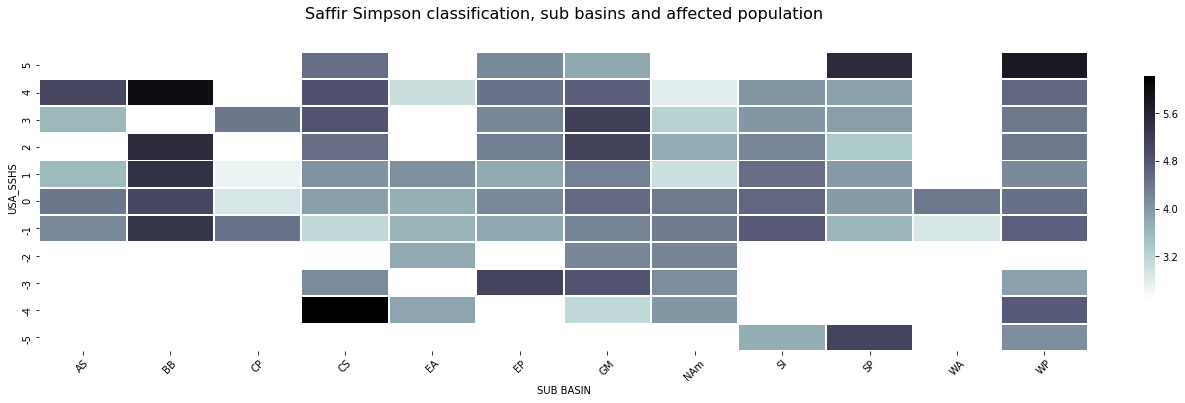

In [23]:
fig, ax = plt.subplots(figsize=(20,6))

#We use the function crosstab in pandas to create a contingency table, crossing USA_SSHS and SUB BASIN by computing the mean of the affected population
sns.heatmap(pd.crosstab(ds_filter["USA_SSHS"], ds_filter["SUB BASIN"], values = ds_filter["TOTAL_AFFECTED"].apply(lambda x: math.log(x, 10)), aggfunc = "mean"),
            cmap="bone_r", 
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ax = ax).set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(ylim=(0, 12));

ax.set_title("Saffir Simpson classification, sub basins and affected population", fontsize= 16);

**Conclusion:** In the basin of West Pacific, the strength of the event seems to be positively correlated with the number of affected people. This behaviour, however, is not totally true in the Bengal Bay where a tropical storm seems to cause more harm that a cyclone category 2. Also, in the Caribean Sea, post tropical events have more impact in the population than cyclones in any category. Notice that most of our data is about events at  West Pacific and Caribean Sea sub-basins.

## 4.5. Plus: Correlation matrix for our numerical features

We will construct a function which allows us to do the same procedure for different datasets:

In [25]:
def get_correlation_matrix(data, method_corr):
    numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
    data_num = data[numerical_variables].copy()
    corr_numbers = data_num.corr(method = method_corr)
    n = len(numerical_variables)
    fig, ax = plt.subplots(figsize=(18,18))

    sns.heatmap(corr_numbers,
                annot = True,
                square=True,
                linewidth=1,# space between cells
                cmap="PRGn", 
                cbar_kws={'fraction' : 0.03}, # shrink colour bar
                ax = ax);
    ax.set(ylim=(0, n));
    ax.set_title(method_corr.capitalize() +" correlation coefficient: All numerical features", fontsize=25);

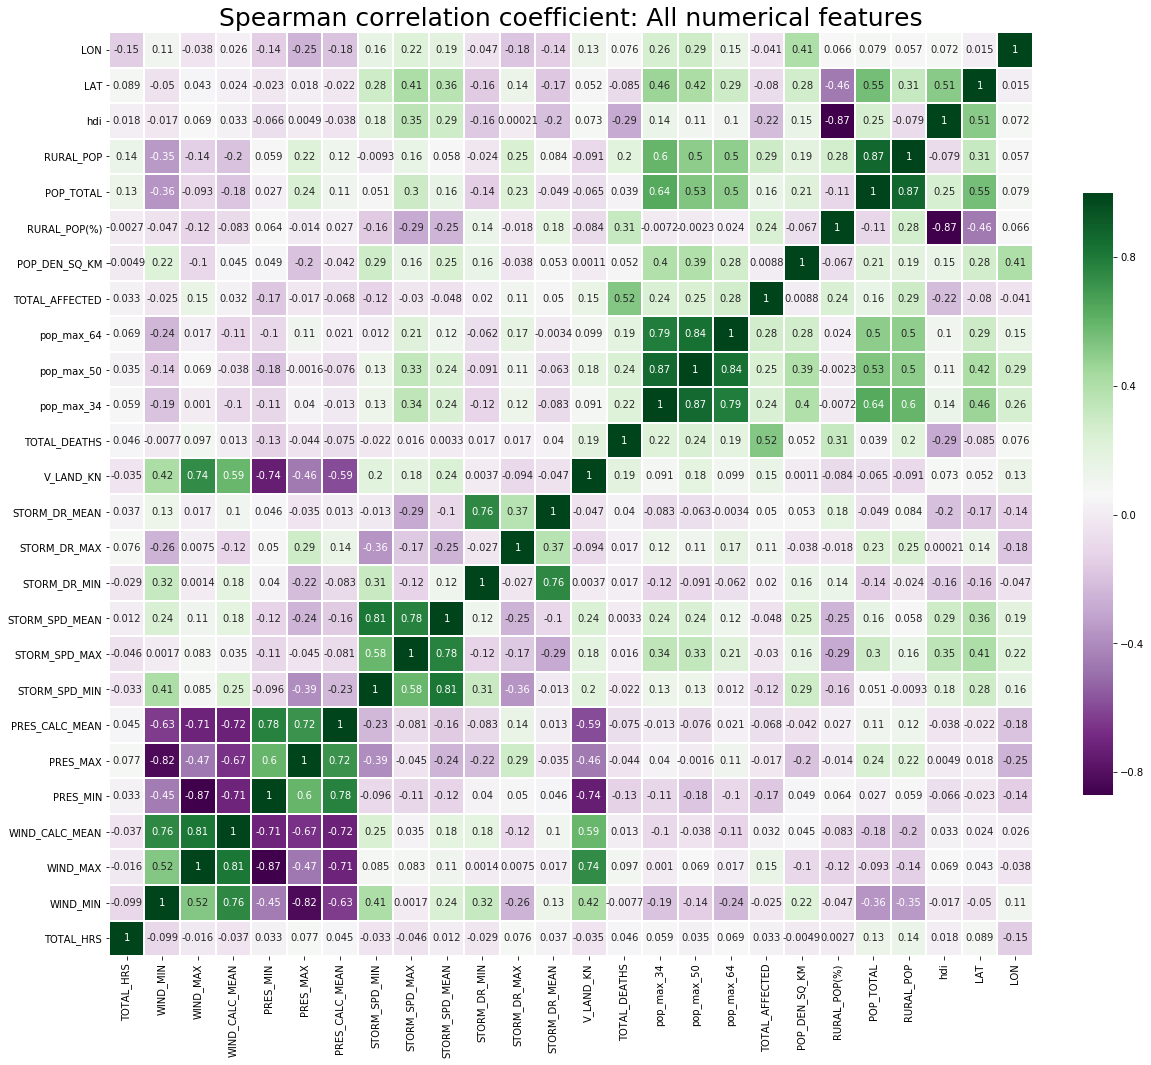

In [26]:
get_correlation_matrix(ds_new, "spearman")

# 5. How is the distribution of the population affected in our data?

As the histogram below show us, the population affected seems to follow approximately a normal distribution, when we consider a logaritmic transformation of it.


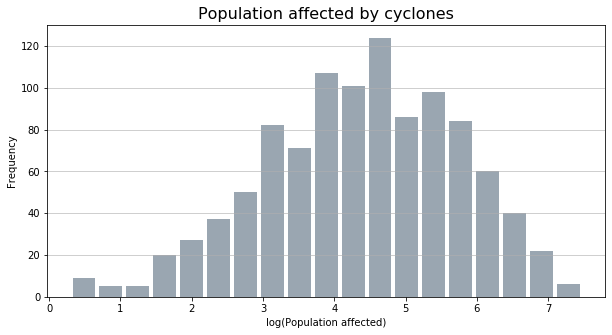

In [27]:

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=ds_new["TOTAL_AFFECTED"].apply(lambda x: math.log(x, 10)), 
                            bins="auto", 
                            color='slategrey',
                            alpha=0.7, 
                            rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('log(Population affected)')
plt.ylabel('Frequency')
plt.title('Population affected by cyclones', fontsize= 16)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);




# 6. Working with Random Forest Regressor

First we will import the relevant libraries.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV

In [29]:
ds_new["RURAL_POP(%)"] = ds_new["RURAL_POP(%)"].apply(lambda x: round(x/100, 3))

In [30]:
train = ds_new.copy()

In [31]:
for col in ['TOTAL_DEATHS','pop_max_34', 'pop_max_50', 'pop_max_64', 'POP_DEN_SQ_KM', 'POP_TOTAL', 'RURAL_POP', 'TOTAL_AFFECTED']:
    train[col] = train[col].apply(lambda x: math.log(x, 10) if x!=0 else 0)

In [32]:
train.drop(columns = ["SID", "NAME", "ISO", "YEAR", "USA_SSHS"], inplace= True)

In [33]:
train.columns

Index(['TOTAL_HRS', 'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN',
       'PRES_MAX', 'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX',
       'STORM_SPD_MEAN', 'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DEATHS', 'pop_max_34', 'pop_max_50', 'pop_max_64',
       'TOTAL_AFFECTED', 'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL',
       'RURAL_POP', 'hdi', 'SUB_BASIN_AS', 'SUB_BASIN_BB', 'SUB_BASIN_CP',
       'SUB_BASIN_CS', 'SUB_BASIN_EA', 'SUB_BASIN_EP', 'SUB_BASIN_GM',
       'SUB_BASIN_NAm', 'SUB_BASIN_SI', 'SUB_BASIN_SP', 'SUB_BASIN_WA',
       'SUB_BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR',
       'NATURE_SS', 'NATURE_TS', 'LAT', 'LON'],
      dtype='object')

Before go further with the modelling part, it is necessary to fill the null values in the data set. We wil create a function to do so, in order to validate the performance of different strategies to fill the null values.

In [34]:
from sklearn.impute import SimpleImputer

In [35]:
def imput_values(data, strategy):
    """
    Returns data imputed following the strategy specified.
    Strategy can be mean, median, most_frequent
    """
    imp_trial=SimpleImputer(missing_values=np.NaN, strategy=strategy)
    idata=pd.DataFrame(imp_trial.fit_transform(data))
    idata.columns=data.columns
    idata.index=data.index
    return idata


In [36]:
def model_validator(data, strategy, test_size, cols, target):
    idata= imput_values(data, strategy)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=42)
    RandomForestRegModel= RandomForestRegressor()
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = cols)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )
    print("R2 Score - imputting values with strategy {}: {}".format(strategy, r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error - imputting values with strategy {}: {}".format(strategy, math.sqrt(mean_squared_error(y_itest, pred_i))))

    

We have a default selection of features. Let us try out the performance of our model within this data:

In [37]:
cols_default = ['TOTAL_HRS', 'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN',
       'PRES_MAX', 'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX',
       'STORM_SPD_MEAN', 'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DEATHS', 'pop_max_34', 'pop_max_50', 'pop_max_64', 
        'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL',
       'RURAL_POP', 'hdi', 'SUB_BASIN_AS', 'SUB_BASIN_BB', 'SUB_BASIN_CP',
       'SUB_BASIN_CS', 'SUB_BASIN_EA', 'SUB_BASIN_EP', 'SUB_BASIN_GM',
       'SUB_BASIN_NAm', 'SUB_BASIN_SI', 'SUB_BASIN_SP', 'SUB_BASIN_WA',
       'SUB_BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR',
       'NATURE_SS', 'NATURE_TS', 'LAT', 'LON']

R2 Score - imputting values with strategy mean: 0.36168379030148745
Squared root of Mean Squared Error - imputting values with strategy mean: 1.0400217383638677


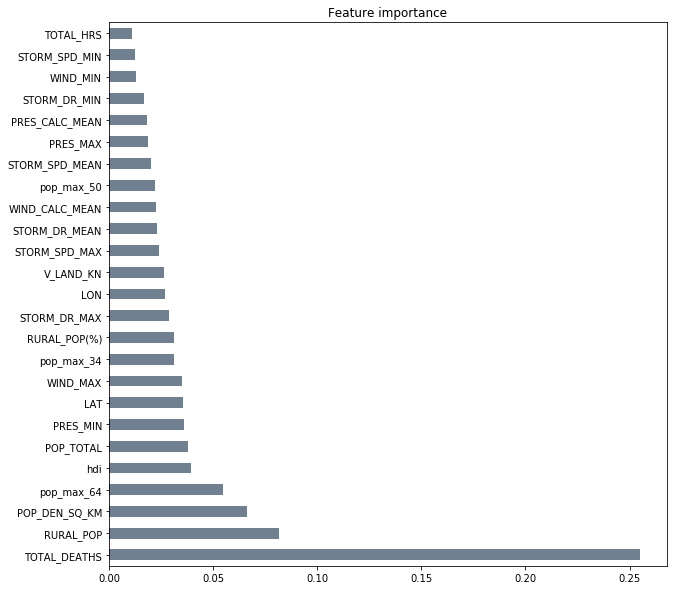

In [38]:
model_validator(train, "mean", 0.30, cols_default,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy mean: 0.36910163848706457
Squared root of Mean Squared Error - imputting values with strategy mean: 1.049341640073589


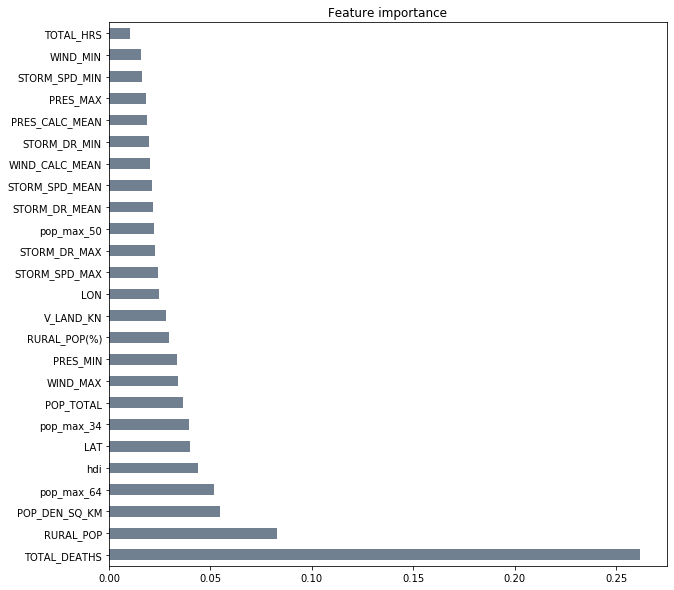

In [39]:
model_validator(train, "mean", 0.20, cols_default,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy mean: 0.39597905251712784
Squared root of Mean Squared Error - imputting values with strategy mean: 1.1055497713071896


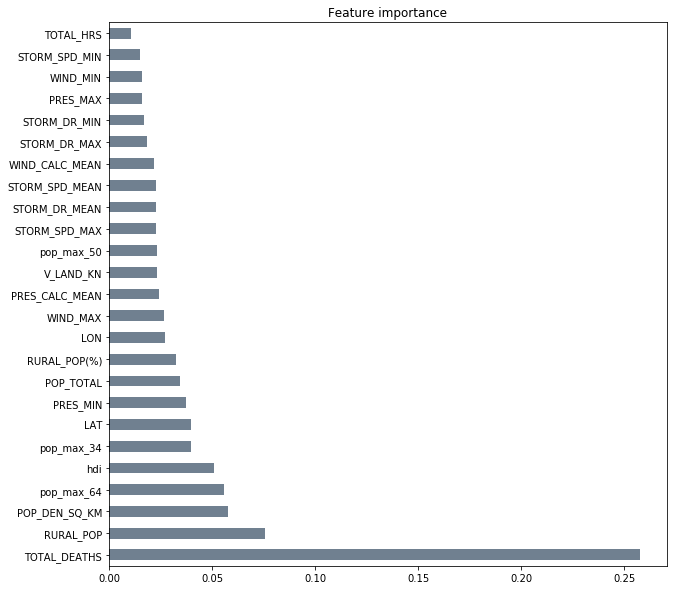

In [40]:
model_validator(train, "mean", 0.10, cols_default,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy mean: 0.3878916652769965
Squared root of Mean Squared Error - imputting values with strategy mean: 1.0518017229821424


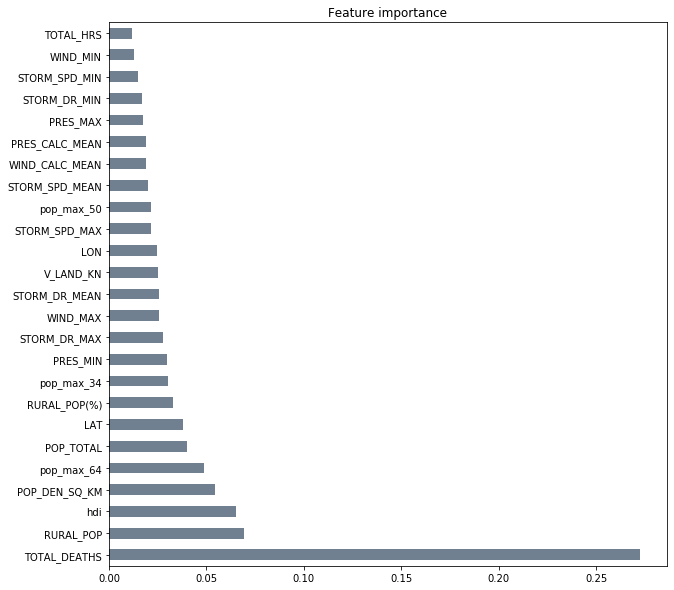

In [41]:
model_validator(train, "mean", 0.40, cols_default,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy most_frequent: 0.3974895586448466
Squared root of Mean Squared Error - imputting values with strategy most_frequent: 1.010431249388105


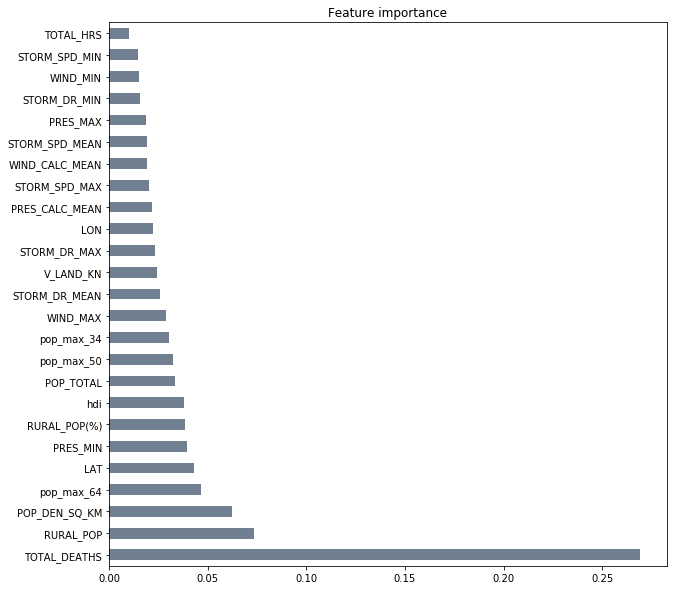

In [42]:
model_validator(train, "most_frequent", 0.30, cols_default,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy median: 0.4071694924859235
Squared root of Mean Squared Error - imputting values with strategy median: 1.095260868071581


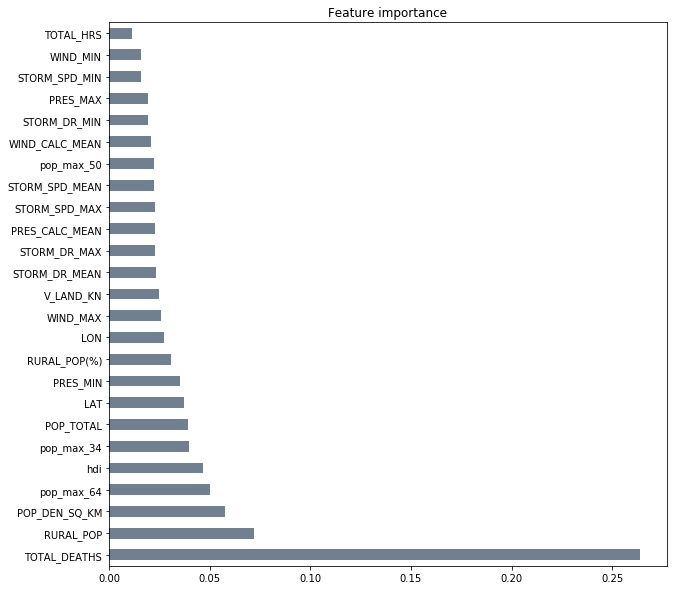

In [43]:
model_validator(train, "median", 0.10, cols_default,'TOTAL_AFFECTED')

Notice that the variable ``TOTAL_DEATHS`` seems to be the most important one in our model which is natural. If a cyclone occurres today, we may have its track so far, its maximum wind and pressure, the HDI of the countries which hits, and the rural and total population nearby. However we don't have access to the **number of deaths** because this is a **consequence of the cyclone**, not a cause. We shouldn't consider this variable in our predictive model.

In [44]:
#Excluding TOTAL_DEATHS from our model

train2 = train[['TOTAL_HRS', 'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN',
       'PRES_MAX', 'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX',
       'STORM_SPD_MEAN', 'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN',
       'V_LAND_KN', 'pop_max_34', 'pop_max_50', 'pop_max_64',
        'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL',
       'RURAL_POP', 'hdi', 'SUB_BASIN_AS', 'SUB_BASIN_BB', 'SUB_BASIN_CP',
       'SUB_BASIN_CS', 'SUB_BASIN_EA', 'SUB_BASIN_EP', 'SUB_BASIN_GM',
       'SUB_BASIN_NAm', 'SUB_BASIN_SI', 'SUB_BASIN_SP', 'SUB_BASIN_WA',
       'SUB_BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR',
       'NATURE_SS', 'NATURE_TS', 'LAT', 'LON', 'TOTAL_AFFECTED']].copy()

features2 = ['TOTAL_HRS', 'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN',
       'PRES_MAX', 'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX',
       'STORM_SPD_MEAN', 'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN',
       'V_LAND_KN', 'pop_max_34', 'pop_max_50', 'pop_max_64', 'POP_DEN_SQ_KM',
       'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'hdi', 'SUB_BASIN_AS',
       'SUB_BASIN_BB', 'SUB_BASIN_CP', 'SUB_BASIN_CS', 'SUB_BASIN_EA',
       'SUB_BASIN_EP', 'SUB_BASIN_GM', 'SUB_BASIN_NAm', 'SUB_BASIN_SI',
       'SUB_BASIN_SP', 'SUB_BASIN_WA', 'SUB_BASIN_WP', 'NATURE_DS',
       'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'LAT',
       'LON']

Now, we run the model_validator function and we found out that the performance of is even worse.

R2 Score - imputting values with strategy mean: 0.3168275629173207
Squared root of Mean Squared Error - imputting values with strategy mean: 1.111181237060824


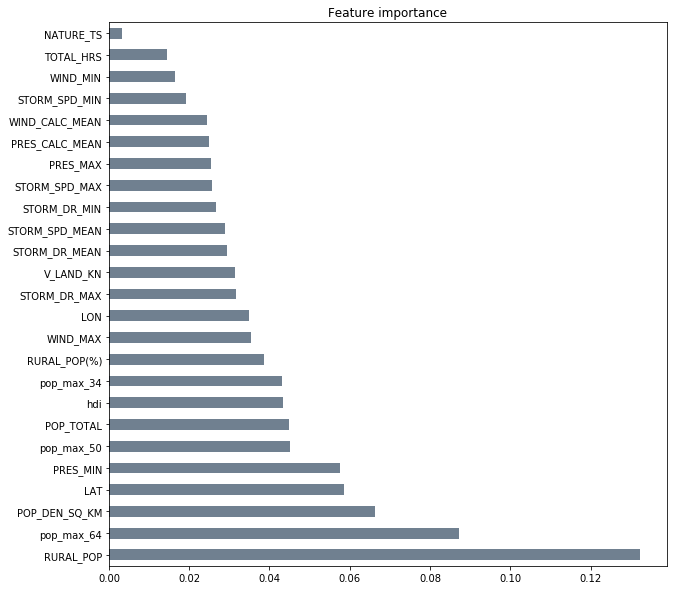

In [46]:
model_validator(train2, "mean", 0.40, features2,'TOTAL_AFFECTED')

Even when the accuracy metric is not that good, the RSMER is not that bad. In our model, which is a primer one, we have a mean error of 13 people in our prediction. Than means that we fail in average by 13 affected people considering our training data.

## 6.  Performance  of model with the original data set

Now, we will explore the performance of our model using the original data set, once dropped columns as ``TOTAL_DEATHS`` and ``TOTAL_DAMAGE_(000$)`` whose data is only available after assessing the occurrence of the cyclone.

In [47]:
#Loading data set
data_original = pd.read_csv("Data_input/OUTPUT_WBI_exposer_cyclones_v4.csv")

In [48]:
#columns to keep
to_keep= ['SUB BASIN', 
       'TOTAL_HRS', 'USA_SSHS',
       'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN', 'PRES_MAX',
       'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX', 'STORM_SPD_MEAN',
       'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN', 'V_LAND_KN',
       '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP',
       '96KN_ASSETS', 'CPI', 
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
        'Population, total', 
       'pop_max_34_adj',
       'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED']

In [49]:
data_selected = data_original[to_keep].copy()

In [50]:
data_selected['USA_SSHS'] = data_selected['USA_SSHS'].astype('category')
data_selected['SUB BASIN'] = data_selected['SUB BASIN'].astype('category')
data_selected['Income_level_Final'] = data_selected['Income_level_Final'].astype('category')

In [51]:
data_selected = pd.get_dummies(data_selected, columns=["SUB BASIN", "USA_SSHS", "Income_level_Final" ], prefix = ["SUB_BASIN", "SCALE", "Income"])# merge with main df bridge_df on key values

In [52]:
for col in ['64KN_POP', '96KN_POP' ,'34KN_POP', "Population density (people per sq. km of land area)", 'Rural population (% of total population)', 'TOTAL_AFFECTED', 'Population, total', 'pop_max_34_adj','pop_max_50_adj', 'pop_max_64_adj']:
    data_selected[col] = data_selected[col].apply(lambda x: math.log(x, 10) if x!=0 else 0)

In [53]:
feat = ['TOTAL_HRS', 'WIND_MIN', 'WIND_MAX', 'WIND_CALC_MEAN', 'PRES_MIN',
       'PRES_MAX', 'PRES_CALC_MEAN', 'STORM_SPD_MIN', 'STORM_SPD_MAX',
       'STORM_SPD_MEAN', 'STORM_DR_MIN', 'STORM_DR_MAX', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS',
       '96KN_POP', '96KN_ASSETS', 'CPI',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Population, total',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
       'SUB_BASIN_AS', 'SUB_BASIN_BB', 'SUB_BASIN_CP', 'SUB_BASIN_CS',
       'SUB_BASIN_EA', 'SUB_BASIN_EP', 'SUB_BASIN_GM', 'SUB_BASIN_NAm',
       'SUB_BASIN_SI', 'SUB_BASIN_SP', 'SUB_BASIN_WA', 'SUB_BASIN_WP',
       'SCALE_-5', 'SCALE_-4', 'SCALE_-3', 'SCALE_-2', 'SCALE_-1', 'SCALE_0',
       'SCALE_1', 'SCALE_2', 'SCALE_3', 'SCALE_4', 'SCALE_5', 'Income_High',
       'Income_High_Middle', 'Income_Low', 'Income_Low_Middle']

R2 Score - imputting values with strategy median: 0.2953570354843579
Squared root of Mean Squared Error - imputting values with strategy median: 1.1624691203370487


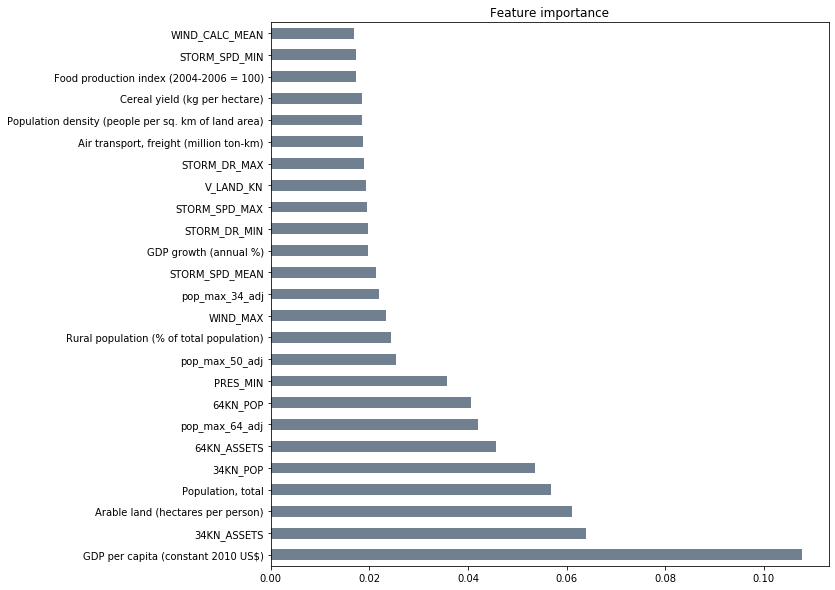

In [54]:
model_validator(data_selected, "median", 0.30, feat,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy mean: 0.2941416332570227
Squared root of Mean Squared Error - imputting values with strategy mean: 1.1634712298510093


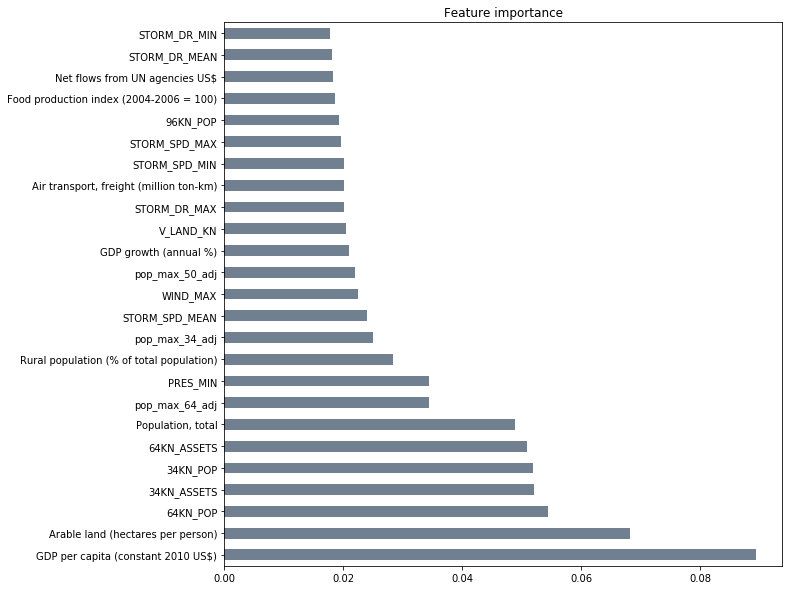

In [55]:
model_validator(data_selected, "mean", 0.30, feat,'TOTAL_AFFECTED')

In [56]:
model_validator(data_selected, "most_frequent", 0.30, feat,'TOTAL_AFFECTED')

R2 Score - imputting values with strategy most_frequent: 0.29305981383936297
Squared root of Mean Squared Error - imputting values with strategy most_frequent: 1.1643624737107812


Considering this data set, the accuracy goes up but the RMSE is about 15 people, so little more than considering the other features.